## Tutorial IFTA DISTANCIAS ESCALAR

**Autor**: Ángela Soria García

**Fecha**: 30/01/2023

**Objetivos** 

    - Optimizar el espacio de fases para modular en amplitud, fase o ambas. Para ello, utilizamos la matriz de Jones experimental del SLM (Holoeye 2500 (comprobar)). 

    - IFTA distancias para las tres configuraciones (amplitud,fase y mixto) y comprobar los parámetros de calidad.
    
    - También se comparará con el IFTA estándar para comprobar si el IFTA por distancias es realmente una mejora.

    - IFTA en campo cercano.


**Procedimiento**

    1º Añadir láser azul al polarímetro.

    2ª Calibrar en las dos longitudes de onda las láminas.

    3ª Calibrar el SLM.
    
    4ª Ver en campo lejano el flat-top.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from py_pol.jones_matrix import Jones_matrix
from py_pol.jones_vector import Jones_vector
from py_pol.mueller import Mueller

from py_pol import degrees

import matplotlib.pyplot as plt

from py_aocg.SLM_system import cargar_Jones_SLM, SLM_system_field, optimization_loop_standard, cost_function_distances_standard, cost_phase,cost_amplitude, circular_phase_space, optimization_loop, cost_function_distances
from py_aocg.ifta.algorithms import distances_scalar


from pyswarms.single.global_best import GlobalBestPSO
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)

In [7]:
plt.rcParams["figure.figsize"] = (6,6)


# 1º: Optimización del espacio de fases

In [63]:
S_incident=Jones_vector('incident')
S_incident.circular_light(intensity=2)

Jslm=cargar_Jones_SLM(type="Jones",filename='SLM_Jones_components.npz')

In [57]:
#Espacio de fases teórico

size_x_DOE, size_y_DOE = 15,15
doe_real = np.linspace(-1,1, size_x_DOE)
doe_imag = np.linspace(-1,1, size_y_DOE)

DOE_real, DOE_imag = np.meshgrid(doe_real, doe_imag)

DOE = DOE_real + 1j*DOE_imag

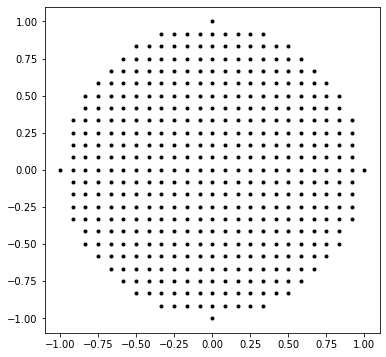

In [58]:
phase_space = circular_phase_space(25,25,has_draw=True)

In [59]:
options = {'c1': 0.5, 'c2': 0.6, 'w': 0.9}
dimensions = 4
min_bound = np.zeros(dimensions); max_bound = np.ones(dimensions)*360*degrees
bounds = (min_bound, max_bound)

iters=70
n_particles=70

## Mixto

En el proceso de optimización minimizamos las distancias al espacio de fases para que lo rellene lo máximo posible

In [60]:
optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=dimensions, options=options, bounds=bounds)

In [61]:
%%time 
cost, angles_mixto = optimizer.optimize(optimization_loop,iters,Jslm=Jslm, S_incident=S_incident,phase_space=phase_space,optimize_function=cost_function_distances)

2023-01-31 10:06:20,883 - pyswarms.single.global_best - INFO - Optimize for 70 iters with {'c1': 0.5, 'c2': 0.6, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|70/70, best_cost=0.155
2023-01-31 10:07:03,696 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.15545231285256295, best pos: [1.05235884 1.35191162 5.77278321 5.82306835]


CPU times: total: 41.8 s
Wall time: 42.8 s


Text(0.5, 0.98, 'amplitude')

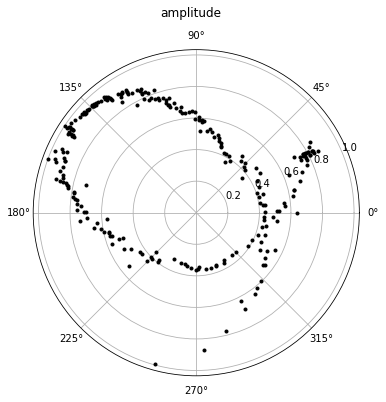

In [62]:
u_fab_amp_mixto, u_fab_phase_mixto, fields=SLM_system_field(angles_mixto, Jslm, E0=S_incident)
u_fab_mixto = u_fab_amp_mixto*np.exp(1j*u_fab_phase_mixto)

plt.polar(u_fab_phase_mixto,u_fab_amp_mixto,'k.')
plt.suptitle('amplitude')

## Fase

Para obtener una modulación de fase utilizamos la siguiente función de mérito:

$MF = - (\phi_{max} - \phi_{min}) / \sigma_A$

In [21]:
optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=dimensions, options=options, bounds=bounds)

In [23]:
%%time 
cost, angles_phase = optimizer.optimize(optimization_loop,iters,Jslm=Jslm,S_incident=None,phase_space=None,optimize_function=cost_phase)

2023-01-31 09:37:29,239 - pyswarms.single.global_best - INFO - Optimize for 70 iters with {'c1': 0.5, 'c2': 0.6, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|70/70, best_cost=-690
2023-01-31 09:38:00,220 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -690.2890111271088, best pos: [2.04209445 3.27845699 3.1018413  1.75584455]


CPU times: total: 30.7 s
Wall time: 31 s


In [20]:
u_fab_amp_phase, u_fab_phase_phase, fields=SLM_system_field(angles_phase, Jslm, E0=S_incident)

Text(0.5, 0.98, 'amplitude')

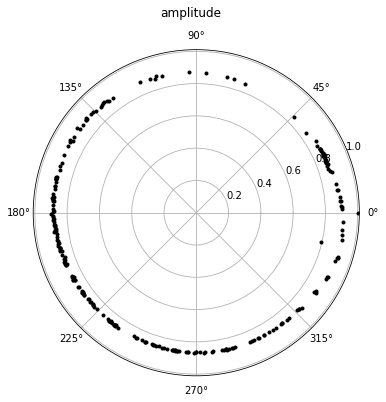

In [26]:
u_fab_phase = u_fab_amp_phase*np.exp(1j*u_fab_phase_phase)


plt.polar(u_fab_phase_phase,u_fab_amp_phase,'k.')
plt.suptitle('amplitude')

## Amplitud

Para obtener una modulación de amplitud utilizamos la siguiente función de mérito:

$MF = - (A_{max} - A_{min}) / \sigma_{\phi}$

In [29]:
optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=dimensions, options=options, bounds=bounds)

In [30]:
%%time 
cost, angles_amp = optimizer.optimize(optimization_loop,iters,Jslm=Jslm,S_incident=None,phase_space=None,optimize_function=cost_amplitude)

2023-01-31 09:44:59,048 - pyswarms.single.global_best - INFO - Optimize for 70 iters with {'c1': 0.5, 'c2': 0.6, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|70/70, best_cost=-10.8
2023-01-31 09:45:22,619 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -10.759958431899454, best pos: [3.53151876 2.18636239 4.35576566 2.93656863]


CPU times: total: 23.5 s
Wall time: 23.6 s


In [31]:
u_fab_amp_amp, u_fab_phase_amp, fields=SLM_system_field(angles_amp, Jslm, E0=S_incident)

Text(0.5, 0.98, 'amplitude')

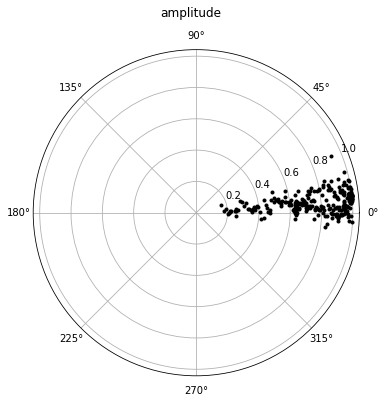

In [34]:
u_fab_amp = u_fab_amp_amp*np.exp(1j*u_fab_phase_amp)
plt.polar(u_fab_phase_amp,u_fab_amp_amp,'k.')
plt.suptitle('amplitude')

# IFTA distancias

In [35]:
from diffractio import um, mm, nm, np, sp, plt, degrees
from diffractio.scalar_masks_XY import Scalar_mask_XY
from diffractio.scalar_sources_XY import Scalar_source_XY

from diffractio.utils_drawing import draw_several_fields

In [36]:
from py_aocg.ifta.parameters import verify_mask, make_binary,RMSE
#from py_aocg.ifta.algorithms import mean_square_error, mnse
from py_aocg.ifta.algorithms import GS_distances_far

In [37]:
num_x=128
num_y=128
DOE_size=40*um

x=np.linspace(-DOE_size/2,DOE_size/2, num_x)
y=np.linspace(-DOE_size/2,DOE_size/2, num_y)
wavelength=0.6328*um

source=Scalar_source_XY(x,y,wavelength)
source.plane_wave()

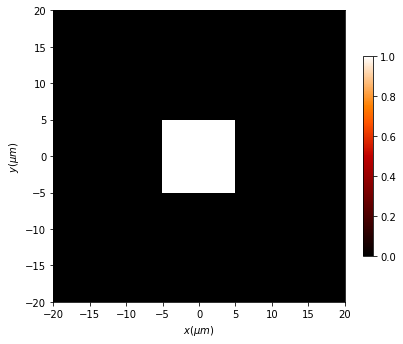

In [38]:
target=Scalar_mask_XY(x,y,wavelength)
target.square(r0=(0,0), size=(10,10), angle=0)
target.draw(has_colorbar='vertical');

I_target=target.intensity()

In [39]:
num_steps=50

# IFTA distancias - Mapa de fase MIXTO

49/50 - error 0.036982 %

CPU times: total: 6.03 s
Wall time: 6.03 s


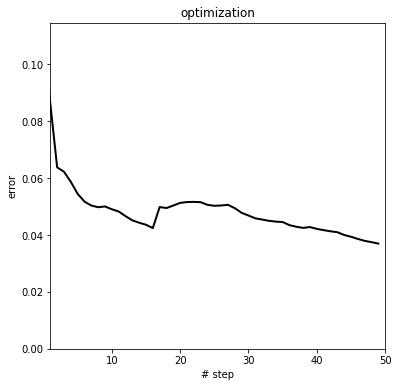

In [40]:
%%time
DOE_mixto, mask_final_mixto, errors_mixto,i_positions_mixto = GS_distances_far(u_fab_mixto,target, num_steps=num_steps, has_draw=True)

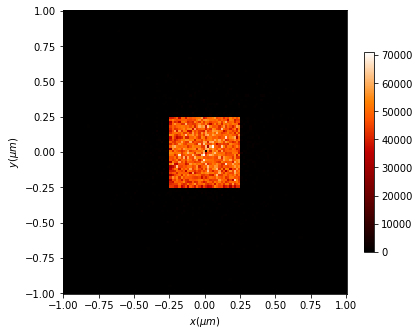

In [41]:
u_far_mixto = DOE_mixto.fft(new_field=True, remove0=True)
#u_far_new.normalize()
u_far_mixto.draw(has_colorbar='vertical', logarithm=0);

I_mixto=u_far_mixto.intensity()
I_mixto=I_mixto/I_mixto.max()

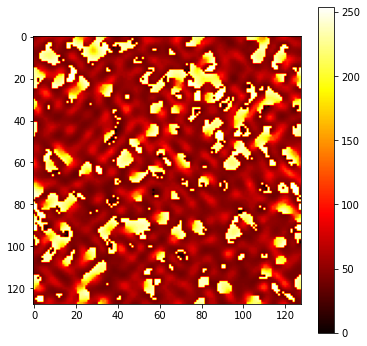

In [42]:
plt.imshow(i_positions_mixto, cmap='hot')
plt.colorbar()

# IFTA distancias - Mapa de fase FASE

49/50 - error 0.045552 %

CPU times: total: 6.06 s
Wall time: 6.08 s


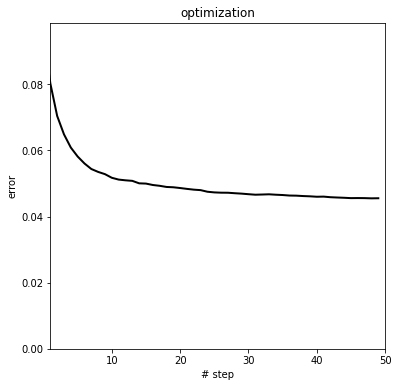

In [43]:
%%time
DOE_phase, mask_final_phase, errors_phase,i_positions_phase = GS_distances_far(u_fab_phase,target, num_steps=num_steps, has_draw=True)

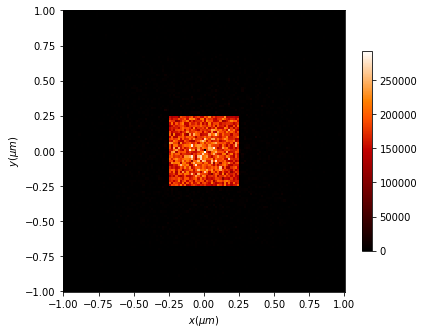

In [44]:
u_far_phase = DOE_phase.fft(new_field=True, remove0=True)
#u_far_new.normalize()
u_far_phase.draw(has_colorbar='vertical', logarithm=0);

I_phase=u_far_phase.intensity()
I_phase=I_phase/I_phase.max()

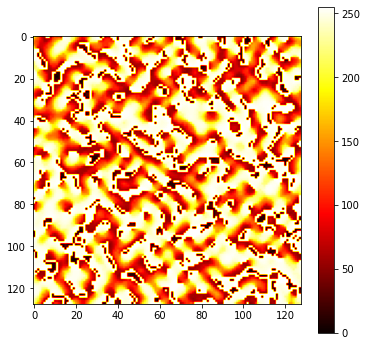

In [45]:
plt.imshow(i_positions_phase, cmap='hot')
plt.colorbar()

# IFTA distancias - Mapa de fase AMPLITUD

49/50 - error 0.249874 %

CPU times: total: 6.27 s
Wall time: 6.27 s


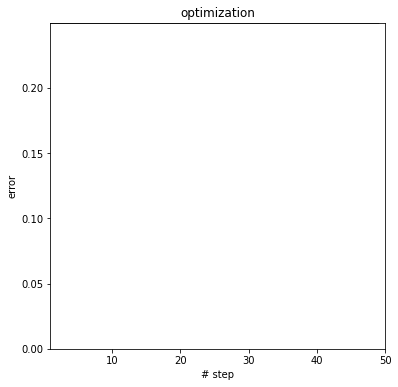

In [46]:
%%time
DOE_amp, mask_final_amp, errors_amp,i_positions_amp = GS_distances_far(u_fab_amp,target, num_steps=num_steps, has_draw=True)

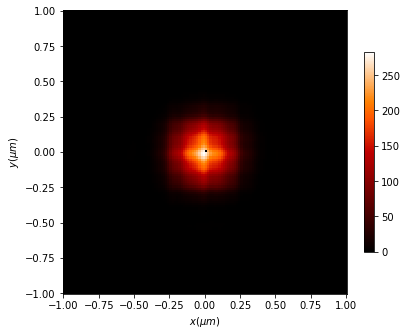

In [52]:
u_far_amp = DOE_amp.fft(new_field=True, remove0=True)
#u_far_new.normalize()
u_far_amp.draw(has_colorbar='vertical', logarithm=0);

I_amp=u_far_amp.intensity()
I_amp=I_amp/I_amp.max()

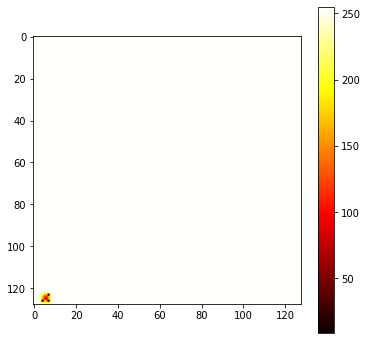

In [53]:
plt.imshow(i_positions_amp, cmap='hot')
plt.colorbar()

# Parametros de las máscaras

In [54]:
from py_aocg.ifta.parameters import compute_parameters

In [55]:
param_mixto = compute_parameters(I_mixto,I_target)
param_phase = compute_parameters(I_phase,I_target)
param_amp = compute_parameters(I_amp,I_target)

print('Mixto:',param_mixto)
print('Fase:',param_phase)
print('Amplitud:',param_amp)


Mixto: (0.9593465345825986, 0.12976152183953785, 0.0046855860557233845)
Fase: (0.9344195439945366, 0.17666442122950196, 0.008085592361411589)
Amplitud: (0.8500439152386126, 0.44948608502239695, 0.03700558880082385)


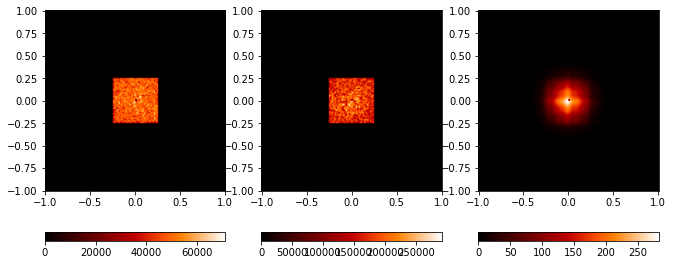

In [51]:
draw_several_fields((u_far_mixto, u_far_phase, u_far_amp))